# Example usage

Here we will demonstrate how to use the helper functions in yarea to load and preprocess a CT image and a corresponding segmentation in DICOM SEG format.

## Imports

In [1]:
from yarea.loaders import loadDicomSITK, loadSegmentation
from yarea.image_processing import flattenImage, alignImages, displayImageSlice

## Load a CT and segmentation

We'll first load in a CT image and segmentation to process.

In [2]:
ctImage = loadDicomSITK("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/3.000000-THORAX_1.0_B45f-95741")

In [3]:
segImages = loadSegmentation("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/1000.000000-3D_Slicer_segmentation_result-67652/1-1.dcm",
                            modality = 'SEG')
print(segImages)

{'Heart': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7faadb122990> >}


We can see here that the segmentation file contained one region of interest labelled 'Heart'.

## Pre-process the segmentation

We can then process the segmentation image so it's ready for analysis with the CT. We process each region of interest (ROI) individually, so we extract the 'Heart' segmentation first.

In [4]:
roiImage = segImages['Heart']

Now, let's ensure the dimensions match between the CT and heart segmentation.

In [5]:
print("CT dimensions: ", ctImage.GetSize())
print("Segmentation dimensions: ", roiImage.GetSize())

CT dimensions:  (512, 512, 304)
Segmentation dimensions:  (512, 512, 304, 1)


We can see that the segmentation has an extra dimension with a length of 1. Let's remove this.

In [6]:
flattenedROIImage = flattenImage(roiImage)
print("Segmentation dimensions: ", flattenedROIImage.GetSize())

Segmentation dimensions:  (512, 512, 304)


Next is aligning the segmentation to the CT.

In [7]:
alignedROIImage = alignImages(ctImage, flattenedROIImage)

## Plot CT image

We can now plot the CT image.

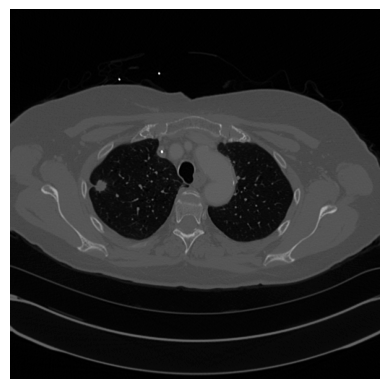

In [8]:
displayImageSlice(ctImage, 240)